# Antarctica Synthetic

Apply EQS GB to the Antarctica synthetic data.

In [1]:
import pandas as pd
import pygmt
import verde as vd
import numpy as np
import pyproj
import matplotlib.pyplot as plt
import eqs_magnetics as eqs
import itertools
import synthetics

Load data from an Antarctic magnetic survey

In [2]:
df = pd.read_csv('../data/victoria_land.csv')
df

C:\Users\iuppal\AppData\Local\Temp\ipykernel_3804\1680060348.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/victoria_land.csv')


,Line,Date,Time,Lat,Lon,Easting,Northing,Upward,Height_WGS84,Project,MagGol
2040251,LG1L10.1,1991/01/01,NaN,-74.68848,162.09804,414493.389433,-8.290939e+06,2700.0,2700.0,GITARA,-62.476330
2040252,LG1L10.1,1991/01/01,NaN,-74.68859,162.09933,414531.970602,-8.290949e+06,2700.0,2700.0,GITARA,-62.500752
2040253,LG1L10.1,1991/01/01,NaN,-74.68869,162.10062,414570.496834,-8.290959e+06,2700.0,2700.0,GITARA,-62.529617
2040254,LG1L10.1,1991/01/01,NaN,-74.68879,162.10188,414608.139331,-8.290968e+06,2700.0,2700.0,GITARA,-62.566840
2040255,LG1L10.1,1991/01/01,NaN,-74.68889,162.10316,414646.370247,-8.290977e+06,2700.0,2700.0,GITARA,-62.610168
...,...,...,...,...,...,...,...,...,...,...,...
4294661,LNVT91,1993/02/01,NaN,-76.12685,161.77679,413770.034807,-8.451695e+06,2700.0,2700.0,GITARA,25.993211
4294662,LNVT91,1993/02/01,NaN,-76.12732,161.77625,413758.465517,-8.451748e+06,2700.0,2700.0,GITARA,25.811278
4294663,LNVT91,1993/02/01,NaN,-76.12778,161.77568,413746.034477,-8.451800e+06,2700.0,2700.0,GITARA,25.631227
4294664,LNVT91,1993/02/01,NaN,-76.12824,161.77513,413734.138943,-8.451852e+06,2700.0,2700.0,GITARA,25.452877


In [3]:
easting = df.Easting.to_numpy()
northing = df.Northing.to_numpy()
upwards = df.Upward.to_numpy()
coordinates = [easting, northing, upwards]

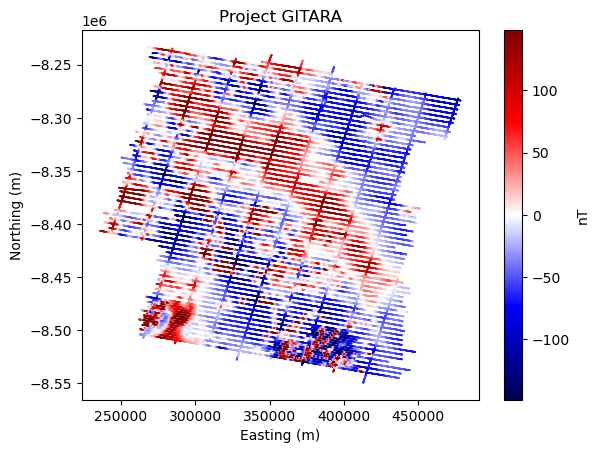

In [4]:
plt.figure()
scale = np.nanpercentile(df.MagGol, 95)
plt.scatter(*coordinates[:2], c=df.MagGol, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.title("Project GITARA")
plt.show()

Create a synthetic source model based on the Antarctic magnetic survey.

In [5]:
field_direction = eqs.angles_to_vector(84, 122, 1)

In [6]:
largest_anomaly_direction = [65, 75]
grid_anomaly_direction = [68, 80]
scatter_anomaly_direction = [40, 45]
north_anomaly_direction = [35, 70]
south_anomaly_direction = [50, 20]
regional_direction = [-88, 78]

source_coordinates, dipole_moments = synthetics.complicated_synthetic(
    largest_anomaly=largest_anomaly_direction,
    grid_anomaly=grid_anomaly_direction,
    scatter_anomaly=scatter_anomaly_direction,
    north_anomaly=north_anomaly_direction,
    south_anomaly=scatter_anomaly_direction,
    regional=regional_direction,
)

In [7]:
b_field = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)

In [8]:
tfa = eqs.total_field_anomaly(b_field, field_direction)
bnorm = eqs.magnetic_field_norm(b_field)

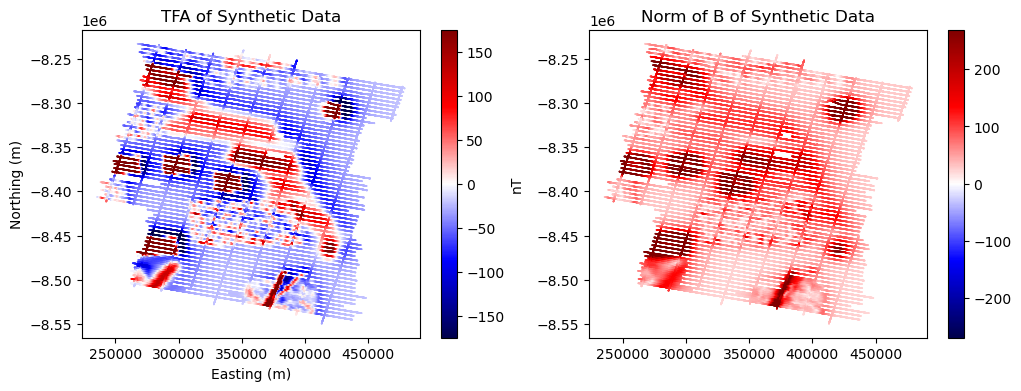

In [9]:
plt.figure(figsize=(12,4))
scale = np.nanpercentile(tfa, 95)
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
scale_bnorm = np.nanpercentile(bnorm, 95)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=bnorm, cmap="seismic",s=0.01, vmin=-scale_bnorm, vmax=scale_bnorm)
plt.title("Norm of B of Synthetic Data")
plt.colorbar()
plt.show()

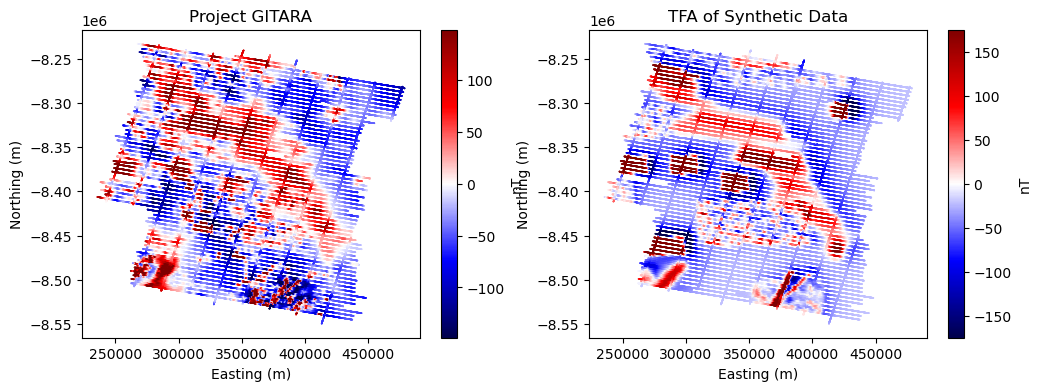

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
scale = np.nanpercentile(df.MagGol, 95)
plt.scatter(*coordinates[:2], c=df.MagGol, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.title("Project GITARA")

plt.subplot(1,2,2)
scale = np.nanpercentile(tfa, 95)
plt.scatter(*coordinates[:2], c=tfa, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit deep source

In [11]:
reducer = vd.BlockReduce(reduction=np.median, spacing=2e4, drop_coords=False)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=tfa)

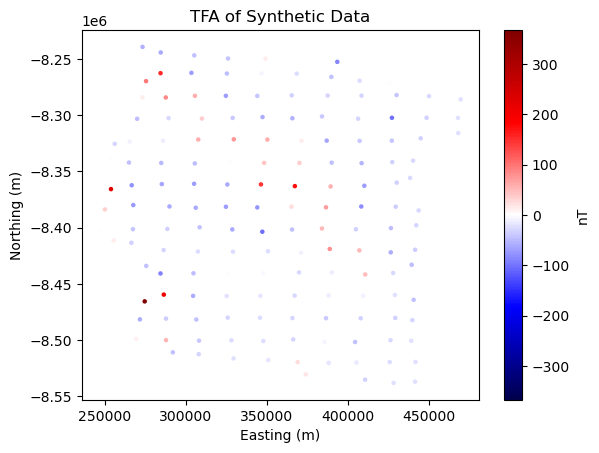

In [12]:
plt.figure()
scale = vd.maxabs(tfa_blocked)
plt.scatter(*coords_blocked[:2], c=tfa_blocked, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

In [13]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(damping=1e-5)
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -65555.3191082565
CPU times: total: 719 ms
Wall time: 746 ms


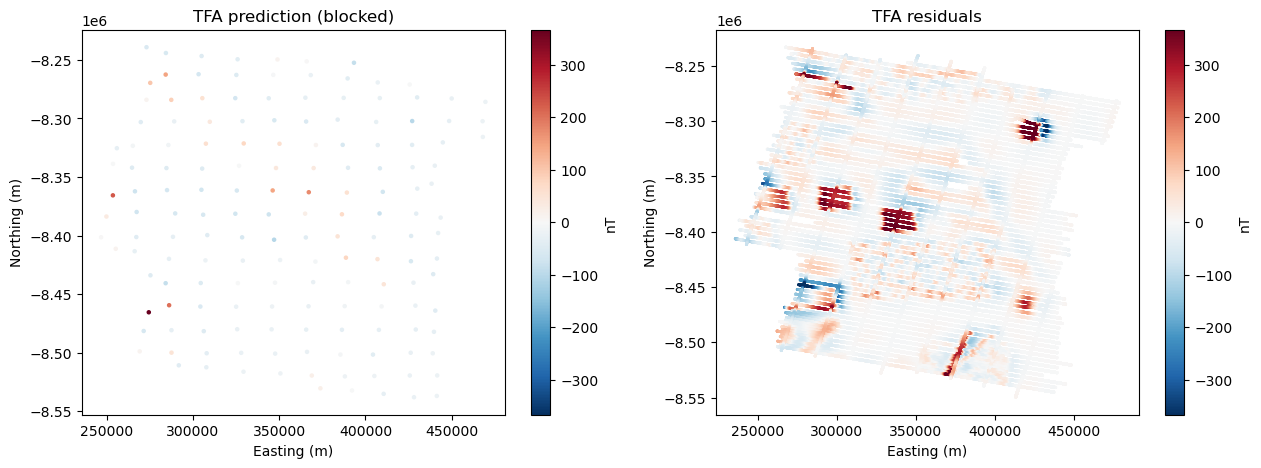

In [14]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = tfa - tfa_deep

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coords_blocked[:2], c=tfa_deep_blocked, cmap="RdBu_r", s=5, vmin=-scale, vmax=scale)
plt.title("TFA prediction (blocked)")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="RdBu_r", s=1, vmin=-scale, vmax=scale)
plt.title("TFA residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit deep residuals with gradient-boosted sources

In [15]:
dampings = [1e-2, 1e-1, 1e1, 1e2]
depths = [250, 500, 750, 1000]
parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
# print("Combinations:", parameter_sets)

Number of combinations: 16


In [16]:
%%time
kfold = vd.BlockKFold(
    spacing=1000,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
for parameters in parameter_sets:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=500, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    scores.append(np.mean(tmp))
    print(np.mean(tmp))

{'damping': 0.01, 'depth': 250}
18847.43956813908
{'damping': 0.01, 'depth': 500}
17051.716152590114
{'damping': 0.01, 'depth': 750}
13917.10267121848
{'damping': 0.01, 'depth': 1000}
10639.841967545588
{'damping': 0.1, 'depth': 250}
18847.43968147567
{'damping': 0.1, 'depth': 500}
17051.71737511128
{'damping': 0.1, 'depth': 750}
13917.115241685602
{'damping': 0.1, 'depth': 1000}
10640.467634878458
{'damping': 10.0, 'depth': 250}
18847.451486232043
{'damping': 10.0, 'depth': 500}
17052.031714534773
{'damping': 10.0, 'depth': 750}
13923.11561632459
{'damping': 10.0, 'depth': 1000}
10691.159665896665
{'damping': 100.0, 'depth': 250}
18847.53964111163
{'damping': 100.0, 'depth': 500}
17057.45805117332
{'damping': 100.0, 'depth': 750}
13970.958363667913
{'damping': 100.0, 'depth': 1000}
10952.95198214775
CPU times: total: 17h 42s
Wall time: 2h 54min 13s


In [17]:
best = np.argmin(scores)
parameter_sets[best]

{'damping': 0.01, 'depth': 1000}

In [18]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=1e3, **parameter_sets[best])
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)

CPU times: total: 8min 35s
Wall time: 1min 24s


In [19]:
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

dipole height: 1700.0
window size: 37607.351938740096


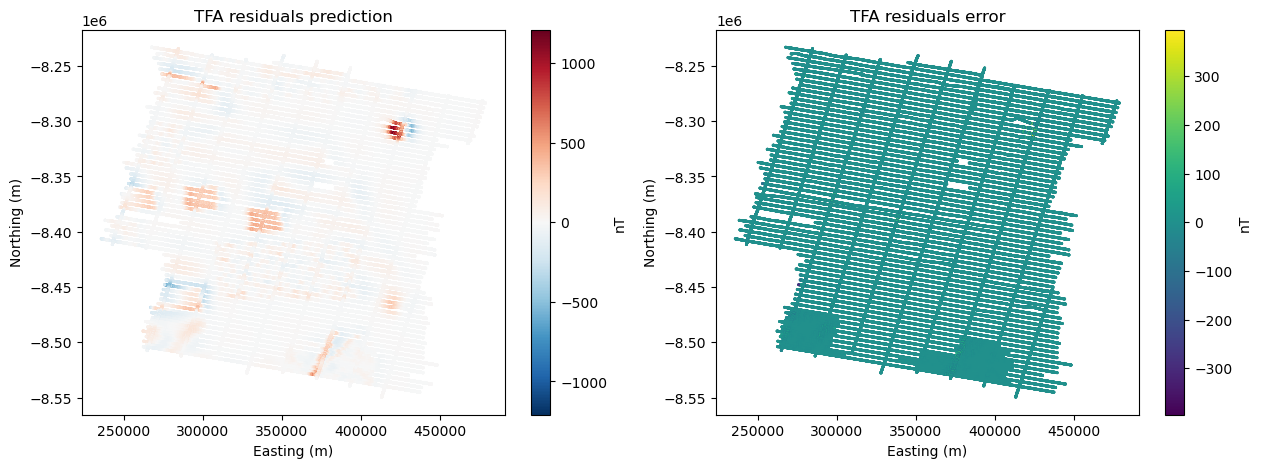

In [20]:
tfa_residuals_prediction = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

scale = vd.maxabs(tfa_residuals_prediction)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_residuals_prediction, cmap="RdBu_r", s=1, vmin=-scale, vmax=scale)
plt.title("TFA residuals prediction")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

error_scale = vd.maxabs(tfa_residuals - tfa_residuals_prediction)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa_residuals - tfa_residuals_prediction, s=1, vmin=-error_scale, vmax=error_scale)
plt.title("TFA residuals error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Predict the norm of B

In [21]:
region = [250000, 450000, -8.55e6, -8.25e6]
grid_coordinates = vd.grid_coordinates(region, spacing=2500, extra_coords=500)
true_tfa = eqs.total_field_anomaly(eqs.dipole_magnetic(grid_coordinates, source_coordinates, dipole_moments), field_direction)
predicted_grid_tfa = eqs.total_field_anomaly((eqs_deep.predict(grid_coordinates) + eqs_shallow.predict(grid_coordinates)), field_direction)
error_tfa = true_tfa - predicted_grid_tfa

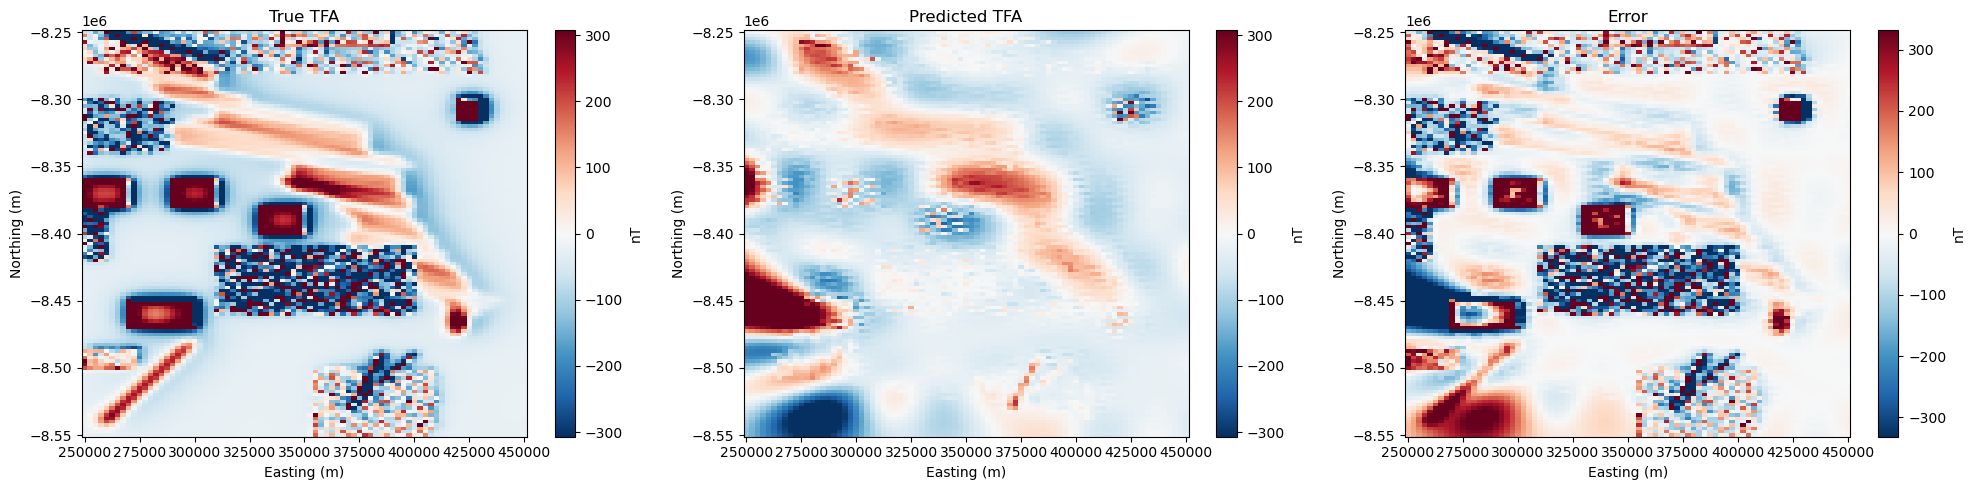

In [22]:
scale_tfa = np.nanpercentile(true_tfa, 95)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="RdBu_r", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_grid_tfa, cmap="RdBu_r", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = np.nanpercentile(error_tfa, 95)
plt.pcolormesh(*grid_coordinates[:2], error_tfa, cmap="RdBu_r", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

In [23]:
true_norm_of_b = np.sqrt(sum(c**2 for c in eqs.dipole_magnetic(grid_coordinates, source_coordinates, dipole_moments)))
predicted_norm_of_b = np.sqrt(sum(c**2 for c in eqs_deep.predict(grid_coordinates) + eqs_shallow.predict(grid_coordinates)))
error = true_norm_of_b - predicted_norm_of_b

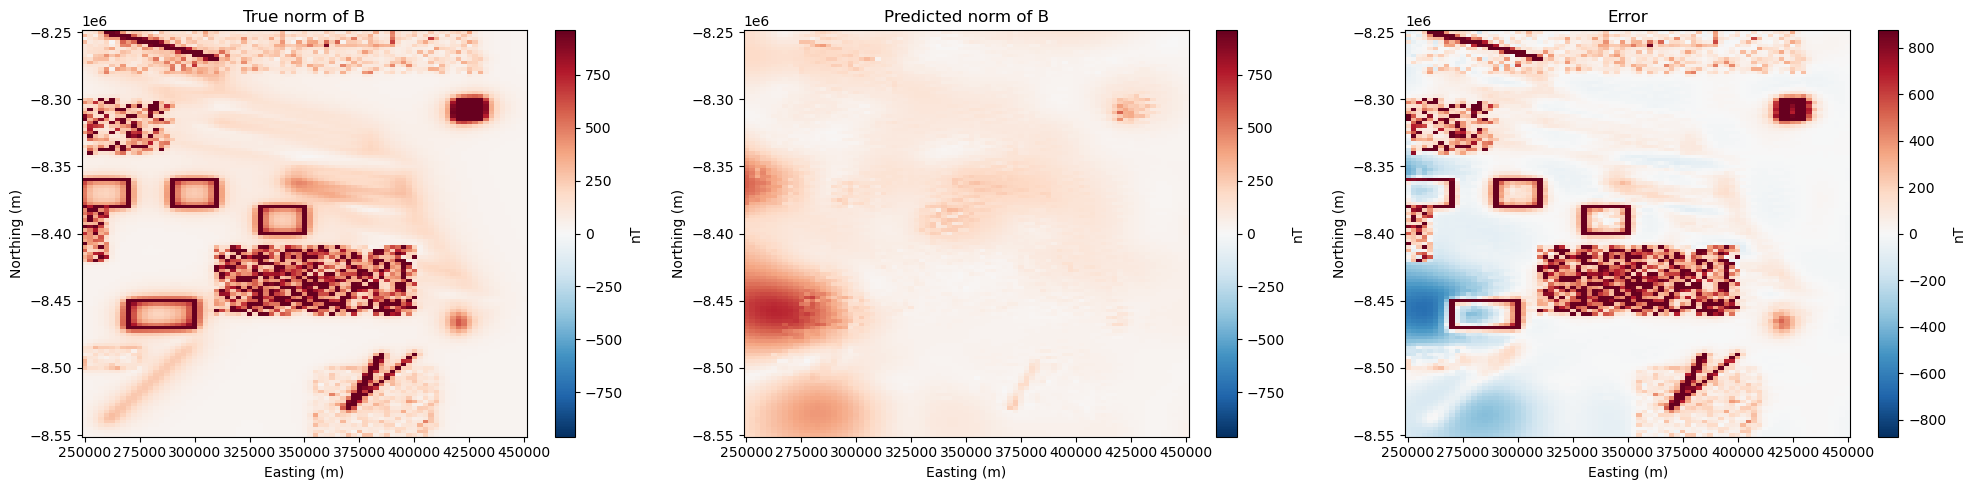

In [24]:
scale_b = np.nanpercentile(true_norm_of_b, 95)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_norm_of_b, cmap="RdBu_r", vmin=-scale_b, vmax=scale_b)
plt.title("True norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_norm_of_b, cmap="RdBu_r", vmin=-scale_b, vmax=scale_b)
plt.title("Predicted norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = np.nanpercentile(error, 95)
plt.pcolormesh(*grid_coordinates[:2], error, cmap="RdBu_r", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()